In [4]:
# %load extract_templates.py
"""
Modified version of:
<https://github.com/connorcoley/ochem_predict_nn/blob/master/data/generate_reaction_templates.py>
"""
#warning: if reaction happens on only changing cis–trans position, this program cannot get its extracted rules
#from global_config import USE_STEREOCHEMISTRY
import re
from tqdm import tqdm
from rdkit.Chem import AllChem
from rdkit import Chem, RDLogger
from itertools import chain, permutations
from multiprocessing import Pool, freeze_support
from collections import defaultdict

# Silence logs
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

def get_special_groups(mol):
    '''Given an RDKit molecule, this function returns a list of tuples, where
    each tuple contains the AtomIdx's for a special group of atoms which should 
    be included in a fragment all together. This should only be done for the 
    reactants, otherwise the products might end up with mapping mismatches'''

#   if SUPER_GENERAL_TEMPLATES: return []

    # Define templates, based on Functional_Group_Hierarchy.txt from Greg Laandrum
    group_templates = [ 
        'C(=O)Cl', # acid chloride
        'C(=O)[O;H,-]', # carboxylic acid
        '[$(S-!@[#6])](=O)(=O)(Cl)', # sulfonyl chloride
        '[$(B-!@[#6])](O)(O)', # boronic acid
        '[$(N-!@[#6])](=!@C=!@O)', # isocyanate
        '[N;H0;$(N-[#6]);D2]=[N;D2]=[N;D1]', # azide
        'O=C1N(Br)C(=O)CC1', # NBS brominating agent
        'C=O', # carbonyl
        'ClS(Cl)=O', # thionyl chloride
        '[Mg][Br,Cl]', # grinard (non-disassociated)
        '[#6]S(=O)(=O)[O]', # RSO3 leaving group
        '[O]S(=O)(=O)[O]', # SO4 group
        '[N-]=[N+]=[C]', # diazo-alkyl
        ]

    # Build list
    groups = []
    for template in group_templates:
        matches = mol.GetSubstructMatches(Chem.MolFromSmarts(template))
        groups.extend(list(matches))
    return groups

def canonicalize_template(template):
    '''This function takes one-half of a template SMARTS string
    (i.e., reactants or products) and re-orders them based on
    an equivalent string without atom mapping.'''

    # Strip labels to get sort orders
    template_nolabels = re.sub('\:[0-9]+\]', ']', template)

    # Split into separate molecules *WITHOUT wrapper parentheses*
    template_nolabels_mols = template_nolabels[1:-1].split(').(')
    template_mols          = template[1:-1].split(').(')

    # Split into fragments within those molecules
    for i in range(len(template_mols)):
        nolabel_mol_frags = template_nolabels_mols[i].split('.')
        mol_frags         = template_mols[i].split('.')

        # Get sort order within molecule, defined WITHOUT labels
        sortorder = [j[0] for j in sorted(enumerate(nolabel_mol_frags), key = lambda x:x[1])]

        # Apply sorting and merge list back into overall mol fragment
        template_nolabels_mols[i] = '.'.join([nolabel_mol_frags[j] for j in sortorder])
        template_mols[i]          = '.'.join([mol_frags[j] for j in sortorder])

    # Get sort order between molecules, defined WITHOUT labels
    sortorder = [j[0] for j in sorted(enumerate(template_nolabels_mols), key = lambda x:x[1])]

    # Apply sorting and merge list back into overall transform
    template = '(' + ').('.join([template_mols[i] for i in sortorder]) + ')'

    return template

def reassign_atom_mapping(transform):
    '''This function takes an atom-mapped reaction and reassigns
    the atom-mapping labels (numbers) from left to right, once
    that transform has been canonicalized.
    
    use this function, though reaction with repeated mapping number is a problem when you validate rxn
    from rxn = AllChem.ReactionFromSmarts(reaction)
    ValueError: ChemicalParserException: initMatchers() must be called before runReactants()
    -It's ok to have a duplicate mapping in the products:
    but this isn't allowed in the reactants:
    actually duplicate mapping in reaction is still a legal reaction, you'll lose some reactions for retro-synthesis
    However ReactionFromSmarts(reaction) with no-mapping, you cannot get correct product 
    
    '''

    all_labels = re.findall('\:([0-9]+)\]', transform)

    # Define list of replacements which matches all_labels *IN ORDER*
    replacements = []
    replacement_dict = {}
    counter = 1
    for label in all_labels: # keep in order! this is important
        if label not in replacement_dict:
            replacement_dict[label] = str(counter)
            counter += 1
        replacements.append(replacement_dict[label])

    # Perform replacements in order
    transform_newmaps = re.sub('\:[0-9]+\]',
        lambda match: (':' + replacements.pop(0) + ']'),
        transform)

    return transform_newmaps

def canonicalize_transform(transform):
    '''This function takes an atom-mapped SMARTS transform and
    converts it to a canonical form by, if nececssary, rearranging
    the order of reactant and product templates and reassigning
    atom maps.'''

    transform_reordered = '>>'.join([canonicalize_template(x) for x in transform.split('>>')])
    
    # remove mapping
    #transform_newmaps = re.sub('\:[0-9]+\]',']',transform_reordered)
    #return transform_newmaps
    return reassign_atom_mapping(transform_reordered)

def convert_to_retro(transform):
    '''This function takes a forward synthesis and converts it to a
    retrosynthesis. Only transforms with a single product are kept, since
    retrosyntheses should have a single reactant (and split it up accordingly).'''

    # Split up original transform
    reactants = transform.split('>>')[0]
    products  = transform.split('>>')[1]

    # Don't force products to be from different molecules (?)
    # -> any reaction template can be intramolecular (might remove later)
    #products = products[1:-1].replace(').(', '.')

    # Don't force the "products" of a retrosynthesis to be two different molecules!
    #reactants = reactants[1:-1].replace(').(', '.')

    return '>>'.join([products, reactants])

ATOM_MAP_PROP = 'molAtomMapNumber'
ATOM_EQL_PROPS = [
#    'GetSmarts',
    'GetAtomicNum',
    'GetTotalNumHs',
    'GetFormalCharge',
    'GetDegree',
    'GetNumRadicalElectrons'
]

def wildcard(atom):
    symbol = atom.GetSmarts(allHsExplicit=True, isomericSmiles=False)
    # CUSTOM SYMBOL CHANGES (add something that cannot comefrom getsmarts)
    if atom.GetTotalNumHs() == 0:
        # Be explicit when there are no hydrogens
        if ':' in symbol: # stick H0 before label
            symbol = symbol.replace(':', ';H0:')
                       
        else: # stick before end
            if symbol !='[H-]':
                symbol = symbol.replace(']', ';H0]')

        # print('Being explicit about H0!!!!')
    if atom.GetFormalCharge() == 0:
        # Also be explicit when there is no charge
        if ':' in symbol: 
            symbol = symbol.replace(':', ';+0:')
        else:
            symbol = symbol.replace(']', ';+0]')
    return symbol


def fragmentize(mols, changed_atoms, radius=1, include_unmapped=False, include_ids=None):
    #USE_STEREOCHEMISTRY= False to avoid wrong extracted reactions though losing some STEREOCHEMISTRY reaction which is from non-STEREO to STEREO
    USE_STEREOCHEMISTRY= False
    include_ids = include_ids or set()
    ids = set()
    fragments = []
    for mol in mols:
        center = set()
        atoms = set()
        replacements = []
        # Are we looking for groups? (reactants only->include_unmapped == False)
        if include_unmapped == False:
            groups = get_special_groups(mol)
        else:
            groups = []
            
        for a in mol.GetAtoms():
            if not a.HasProp(ATOM_MAP_PROP):
                if include_unmapped:
                    atoms.add(a)
                    replacements.append((a.GetIdx(), wildcard(a)))
                continue

            id = a.GetProp(ATOM_MAP_PROP)
            if id not in changed_atoms:
                if id in include_ids:
                    atoms.add(a)
                    replacements.append((a.GetIdx(), wildcard(a)))
                continue
                
            # for including leaving groups in reactants
            if not include_unmapped:
                for b in mol.GetAtoms():
                    if not b.HasProp(ATOM_MAP_PROP):
                        # Already included, skip
                        #if b in center: break
                        if b.GetIdx() in [atom.GetIdx() for atom in center]: break
                        center.add(b)
                        replacements.append((b.GetIdx(), wildcard(b)))
                    
            # Prepare symbol replacements
            
            replacements.append((a.GetIdx(), wildcard(a)))
            center.add(a)

        # Include neighbors of changed atoms
        for _ in range(radius):
            to_add = set()
            for a in center:
                for neighbor in a.GetNeighbors():
                    # Already included, skip
                    #if neighbor in atoms: continue
                    if neighbor.GetIdx() in [atom.GetIdx() for atom in center]: continue

                    replacements.append((neighbor.GetIdx(), wildcard(neighbor)))
                    to_add.add(neighbor)
            center = center | to_add

        atoms = center | atoms
        if not atoms: continue

        symbols = [atom.GetSmarts(allHsExplicit=True, isomericSmiles=False) for atom in mol.GetAtoms()]
        for i, symbol in replacements:
            symbols[i] = symbol

        ids = ids | set(a.GetProp(ATOM_MAP_PROP) for a in atoms if a.HasProp(ATOM_MAP_PROP))

        # Clear atom mapping
        [a.ClearProp('molAtomMapNumber') for a in mol.GetAtoms()]

        fragments.append('(' + AllChem.MolFragmentToSmiles(mol, [a.GetIdx() for a in atoms],
                                                           atomSymbols=symbols, allHsExplicit=True,
                                                           isomericSmiles=USE_STEREOCHEMISTRY, allBondsExplicit=True) + ')')

    fragments = '.'.join(fragments)
    return fragments, ids

def bond_to_label(bond):
    '''This function takes an RDKit bond and creates a label describing
    the most important attributes'''
    # atoms = sorted([atom_to_label(bond.GetBeginAtom().GetIdx()), \
    #         atom_to_label(bond.GetEndAtom().GetIdx())])
    a1_label = str(bond.GetBeginAtom().GetAtomicNum())
    a2_label = str(bond.GetEndAtom().GetAtomicNum())
    if bond.GetBeginAtom().HasProp('molAtomMapNumber'):
        a1_label += bond.GetBeginAtom().GetProp('molAtomMapNumber')
    if bond.GetEndAtom().HasProp('molAtomMapNumber'):
        a2_label += bond.GetEndAtom().GetProp('molAtomMapNumber')
    atoms = sorted([a1_label, a2_label])

    return '{}{}{}'.format(atoms[0], str(bond.GetBondType()), atoms[1])

def get_tagged_atoms_from_mols(mols):
    '''Takes a list of RDKit molecules and returns total list of
    atoms and their tags'''
    atoms = []
    atom_tags = []
    for mol in mols:
        new_atoms, new_atom_tags = get_tagged_atoms_from_mol(mol)
        atoms += new_atoms 
        atom_tags += new_atom_tags
    return atoms, atom_tags

def get_tagged_atoms_from_mol(mol):
    '''Takes an RDKit molecule and returns list of tagged atoms and their
    corresponding numbers'''
    atoms = []
    atom_tags = []
    for atom in mol.GetAtoms():
        if ':' in atom.GetSmarts():
            atoms.append(atom)
            atom_tags.append(atom.GetSmarts().split(':')[1][:-1])
    return atoms, atom_tags

def val_rc(reactants, reaction, products):
    '''This function checks if extracted rules are correct,but there is unsolved problems between permutations and rxn.RunReactants. So do not use'''
    # Try all combinations of reactants that fit template
    rxn = AllChem.ReactionFromSmarts(reaction)
    combinations = permutations(reactants, rxn.GetNumReactantTemplates())
    # find the right reactants
#    objs=[]
    
#    for a in rxn.GetReactants():
#        for b in reactants:
#            if b.HasSubstructMatch(a):
#                objs.append(b)
    outcomes =[]            
    products_smi = [Chem.MolToSmiles(mol, allHsExplicit=True,allBondsExplicit=True) for mol in products]
    for combination in combinations:
        try:
            outcomes = rxn.RunReactants(list(combination))
        except Exception as e:
            print('error: {}'.format(e))
            print('rxn: {}'.format(reaction))
            for thing in list(combination):
                print('reactant: {}'.format(Chem.MolToSmiles(thing, allHsExplicit=True,allBondsExplicit=True)))
#            continue
        if not outcomes: continue    
#    try:               
#        outcomes = rxn.RunReactants(objs)
#    except Exception as e:
#        print('error: {}'.format(e))
#        print('rxn: {}'.format(reaction))
#        for thing in objs:
#            print('reactant: {}'.format(Chem.MolToSmiles(thing, allHsExplicit=True,allBondsExplicit=True)))
        
    
#    if not outcomes: return False
#    if outcomes:    
        
        for outcome in outcomes:
            outcomeF=[]
            for k, product in enumerate(outcome):

                try:
                    Chem.SanitizeMol(product)
                    product.UpdatePropertyCache()
                    #create product or reactant using molfromsmarts+sanitizemol is sometimes better than molfromsmiles, but still using molfromsmiles as possible as you can
                    product=Chem.MolFromSmiles(Chem.MolToSmiles(product,allHsExplicit=True,allBondsExplicit=True))
                    
                except Exception as e:
                    #print('warning1: {}'.format(e))
                    #use pass is not good behavior, however i have validation finally
                    break
                if Chem.MolToSmiles(product,allHsExplicit=True,allBondsExplicit=True) not in products_smi:
                    break
                outcomeF.append(product)
                if k == len(outcome)-1:
                    return True
    return False        

def val_rc2(reactants, reaction, products):
    '''This function checks if extracted rules are correct '''
    rxn = AllChem.ReactionFromSmarts(reaction)
    outcomes =[]            
    products_smi = [Chem.MolToSmiles(mol, allHsExplicit=True,allBondsExplicit=True) for mol in products]
    if rxn.GetNumReactantTemplates()!=len(reactants): return [0]
    reactants1=[]
    reactants2=[]
#    reactantr=[]
#    for thing in reactants:
#        thing2=Chem.MolFromSmarts(Chem.MolToSmiles(thing,allHsExplicit=True,allBondsExplicit=True))
#        Chem.SanitizeMol(thing2)
#        reactantr.append(thing2)
    
    try:
        outcomes = rxn.RunReactants(reactants)
    except Exception as e:
        print('error: {}'.format(e))
        print('rxn: {}'.format(reaction))
        
        for thing in reactants:
            print('reactant: {}'.format(Chem.MolToSmiles(thing, allHsExplicit=True,allBondsExplicit=True)))
            thing1=Chem.MolFromSmiles(Chem.MolToSmiles(thing,allHsExplicit=True,allBondsExplicit=True))
            reactants1.append(thing1)
        try:
            outcomes = rxn.RunReactants(reactants1)
        except Exception as e:
            print('error2: {}'.format(e))
            #print('rxn: {}'.format(reaction))
            for thing in reactants1:
                print('reactant1: {}'.format(Chem.MolToSmiles(thing, allHsExplicit=True,allBondsExplicit=True)))
                #thing2=Chem.MolFromSmiles(Chem.MolToSmiles(thing,allHsExplicit=True,allBondsExplicit=True))
                thing2=Chem.MolFromSmarts(Chem.MolToSmiles(thing,allHsExplicit=True,allBondsExplicit=True))
                Chem.SanitizeMol(thing2)
                reactants2.append(thing2)
            try:
                outcomes = rxn.RunReactants(reactants2)
            except Exception as e:
                print('error3: {}'.format(e))
               # print('rxn: {}'.format(reaction))
                for thing in reactants2:
                    print('reactant2: {}'.format(Chem.MolToSmiles(thing, allHsExplicit=True,allBondsExplicit=True)))
                
                       
#           continue
    if not outcomes: return [0] 
    if outcomes:    
        
        for outcome in outcomes:
            outcomeF=[]
            for k, product in enumerate(outcome):

                try:
                    Chem.SanitizeMol(product)
                    product.UpdatePropertyCache()
                    #create product or reactant using molfromsmarts+sanitizemol is sometimes better than molfromsmiles, but still using molfromsmiles as possible as you can
                    product=Chem.MolFromSmiles(Chem.MolToSmiles(product,allHsExplicit=True,allBondsExplicit=True))
                except Exception as e:
                    #print('warning1: {}'.format(e))
                    #use pass is not good behavior, however i have validation finally
                    break
                if not product:
                    break
                if Chem.MolToSmiles(product,allHsExplicit=True,allBondsExplicit=True) not in products_smi:
                    break
                outcomeF.append(product)
                if k == len(outcome)-1:
                    return [1], outcomeF
    return [0]
    
    
def extract(smarts):
    rxn = AllChem.ReactionFromSmarts(smarts)
    products = rxn.GetProducts()
    reactants = rxn.GetReactants()
    agents = rxn.GetAgents()

    # Only consider single product reactions
    if len(products) > 1:
        return

    product = [Chem.Mol(products[0])]
    [a.ClearProp('molAtomMapNumber') for a in product[0].GetAtoms()]
    try: 
        Chem.SanitizeMol(product[0])
        product[0]=Chem.MolFromSmiles(Chem.MolToSmiles(product[0],allHsExplicit=True,allBondsExplicit=True))
    except Exception as e:
        #print('warning2: {}'.format(e))
        return
    product_smi = Chem.MolToSmiles(product[0],allHsExplicit=True,allBondsExplicit=True)
    
    reactant = []
    for mol in reactants:
        obj = Chem.Mol(mol)
        [a.ClearProp('molAtomMapNumber') for a in obj.GetAtoms()]
        try:        
            Chem.SanitizeMol(obj)
            obj=Chem.MolFromSmiles(Chem.MolToSmiles(obj,allHsExplicit=True,allBondsExplicit=True))
            reactant.append(obj)
        except Exception as e:
#            print('warning3: {}'.format(e))
#            print('molTOsmiles: {}'.format(Chem.MolToSmiles(obj, allHsExplicit=True,allBondsExplicit=True)))
#            print('rxn: {}'.format(smarts))
            return
        
    # Sanitize and canonicalize to get the right smarts
    reaction = [products, reactants, agents]
    for num1,mols in enumerate(reaction):
        for num2,mol in enumerate(mols):
            if num1!=2:
                try:
                    Chem.SanitizeMol(mol)
                    #Chem.rdMolTransforms.CanonicalizeMol(mol)
                    reaction[num1][num2]=Chem.MolFromSmiles(Chem.MolToSmiles(mol,allHsExplicit=True,allBondsExplicit=True, isomericSmiles=True))
                
                except Exception as e:
                    print('warning4: {}'.format(e))
                    print('prod0 reac1 agent2: {}'.format(num1))
                    print('molTOSmiles: {}'.format(Chem.MolToSmiles(mol, allHsExplicit=True,allBondsExplicit=True, isomericSmiles=True)))
                    print('rxn: {}'.format(smarts))
                    return
                
    products, reactants, agents = [mols for mols in reaction]

    # Assure that all product atoms are mapped
    # (i.e. we can trace where they came from)
    for prod in products:
        all_mapped = all(a.HasProp(ATOM_MAP_PROP) for a in prod.GetAtoms())
        if not all_mapped:
            return

    #prod_atoms, prod_atom_tags = get_tagged_atoms_from_mols(products)
    #reac_atoms, reac_atom_tags = get_tagged_atoms_from_mols(reactants)
    #'warning: different atom tags appear in reactants and products'
    #if len(set(prod_atom_tags)) != len(set(reac_atom_tags)):
    #    return
    
    #below 3 lines are not necessary, but it can help filter out unsovlable failures, and therefore you can foucus on solving other failures(Todo in the future )
    #'warning: total number of tagged atoms differ, stoichometry != 1? usually happens when 2 indentical reactants form 1 product, but reaction show only 1 reactant '
    #Therefore we will miss some reactions
    #if len(prod_atoms) != len(reac_atoms):
    #    return
        
    
    # THIS IS TOO MUCH
    r_atoms = dict(chain(*[[(a.GetProp(ATOM_MAP_PROP), a) for a in m.GetAtoms() if a.HasProp(ATOM_MAP_PROP)] for m in reactants]))
    p_atoms = dict(chain(*[[(a.GetProp(ATOM_MAP_PROP), a) for a in m.GetAtoms() if a.HasProp(ATOM_MAP_PROP)] for m in products]))

    # Should consist of the same tags and atoms
    # TODO looks like they may not necessarily have the same tags?
    # "leaving atoms"?
    #'warning: different atom tags appear in reactants and products'
    if set(r_atoms.keys()) != set(p_atoms.keys()) \
            or len(r_atoms) != len(p_atoms): return

    changed_atoms = []
    for id, r_atom in r_atoms.items():
        p_atom = p_atoms[id]
        #to avoid wrong extracted reactions though losing some STEREOCHEMISTRY reaction which is from non-STEREO to STEREO
        #below 3 lines are not necessary, but it can help filter out unsovlable failures, and therefore you can foucus on solving other failures(Todo in the future )
        #if p_atom.GetChiralTag() != r_atom.GetChiralTag():
            #if (p_atom.GetChiralTag() == Chem.rdchem.ChiralType.CHI_UNSPECIFIED) or (r_atom.GetChiralTag() == Chem.rdchem.ChiralType.CHI_UNSPECIFIED):
                #return
        
        
        eql = all([getattr(p_atom, prop)() == getattr(r_atom, prop)() for prop in ATOM_EQL_PROPS])
        
        # Check bonds and nearest neighbor identity
        
        bonds1 = sorted([bond_to_label(bond) for bond in r_atom.GetBonds()]) 
        bonds2 = sorted([bond_to_label(bond) for bond in p_atom.GetBonds()]) 
        #, getattr(p_atom,'GetSmarts')(allHsExplicit=True, isomericSmiles=False) == getattr(r_atom,'GetSmarts')(allHsExplicit=True, isomericSmiles=False)
        eql = all([eql, bonds1 == bonds2, getattr(p_atom,'GetSmarts')(allHsExplicit=True, isomericSmiles=False) == getattr(r_atom,'GetSmarts')(allHsExplicit=True, isomericSmiles=False)])       
        if not eql:
            changed_atoms.append(id)

    # TODO "leaving" atoms?

    # Get fragments for reactants and products
    reactant_frags, reactant_ids = fragmentize(reactants, changed_atoms, radius=0)
    product_frags, _ = fragmentize(products, changed_atoms, radius=0, include_unmapped=True, include_ids=reactant_ids)

    transform = '{}>>{}'.format(reactant_frags, product_frags)

    # Validate
    try:
        rxn = AllChem.ReactionFromSmarts(transform)
        _, n_errs = rxn.Validate(silent=True)
        if n_errs > 0:
            return
    except Exception as e:
        print('warning5: {}'.format(e))
        print('transform: {}'.format(transform))
        print('smarts: {}'.format(smarts))
        return
 

    rxn_canonical = canonicalize_transform(transform)
    retro_canonical = convert_to_retro(rxn_canonical)
    

    # Validate
    try:
        rxn = AllChem.ReactionFromSmarts(retro_canonical)
        _, n_errs = rxn.Validate(silent=True)
        if n_errs > 0:
            #print('warning: {}'.format(retro_canonical))
            #print('warning: {}'.format(smarts))
            return    
    except Exception as e:
        print('warning5: {}'.format(e))
        print('transform: {}'.format(retro_canonical))
        print('smarts: {}'.format(smarts))
        return

    
    

    val=[]
    val2=[]
    reacs=[]
    val=val_rc2(product, retro_canonical, reactant)
    if len(val)==2:
        val2=val_rc2(val[1], rxn_canonical, product)
        if len(val2)==2:
            for rea in val[1]:
                reacs.append(Chem.MolToSmiles(rea,allHsExplicit=True,allBondsExplicit=True))
            reactant_smi= ' ++ '.join(reacs)
            return retro_canonical, product_smi, reactant_smi
        else:
            return rxn_canonical, product_smi, smarts, [0]
    else:
        return retro_canonical, product_smi, smarts, [0]
    
def clean(line): return line.strip().split()[0]

transforms = []
failure = []

with open('data/reactions.rsmi', 'r') as f:
# pool is difficult to use in window systems
#    if __name__ == '__main__':
#        freeze_support()
#        with Pool() as p:
#            for res in tqdm(p.imap(extract, map(clean, f))):
            for smarts in tqdm(map(clean, f)):
                res= extract(smarts)
# the two lines above are used to solve pool problem
                if res is None: continue
                if len(res) == 3:
                    rxn, product, reactant = res
                    transforms.append((rxn, product, reactant))
                else:
                    rxn, product, sample, _ = res
                    failure.append((rxn, product, sample))                    

with open('data/templates.dat', 'w') as f:
    f.write('\n'.join(['\t'.join(rxn_prod) for rxn_prod in transforms]))

if failure:
    with open('data/failures.dat', 'w') as f:
        f.write('\n'.join(['\t'.join(rxn_prod) for rxn_prod in failure]))

# Generate rules for MCTS
templates = defaultdict(int)
for rule, _, __ in transforms:
    templates[rule] += 1
Tlexp=0
Tlrol=0
expcount=4
rollcount=15

expansion = [rule for rule, count in templates.items() if count >= expcount]
print('Expansion rules:', len(expansion))

for rule, count in templates.items():
    if count >= expcount:
        Tlexp += count
print('total Expansion rules examples:', Tlexp)
with open('data/expansion.dat', 'w') as f:
    f.write('\n'.join(expansion))

rollout = [rule for rule, count in templates.items() if count >= rollcount]
print('Rollout rules:', len(rollout))

for rule, count in templates.items():
    if count >= rollcount:
        Tlrol += count
print('total Rollout rules examples:', Tlrol)
with open('data/rollout.dat', 'w') as f:
    f.write('\n'.join(rollout))

58it [00:00, 204.07it/s]


Expansion rules: 3
total Expansion rules examples: 15
Rollout rules: 0
total Rollout rules examples: 0


In [3]:
import re
from tqdm import tqdm
from rdkit.Chem import AllChem
from rdkit import Chem, RDLogger
from itertools import chain, permutations
from multiprocessing import Pool, freeze_support
from collections import defaultdict

from testa import extract, clean

if __name__ == '__main__':
    
    transforms = []
    failure = []
    
    with open('data/reactions-r.rsmi', 'r') as f:
    # pool is difficult to use in window systems
    #    if __name__ == '__main__':
    #        freeze_support()
            with Pool() as p:
                for res in tqdm(p.imap(extract, map(clean, f))):
    #            for smarts in tqdm(map(clean, f)):
    #                res= extract(smarts)
    # the two lines above are used to solve pool problem
                    if res is None: continue
                    if len(res) == 3:
                        rxn, product, reactant = res
                        transforms.append((rxn, product, reactant))
                    else:
                        rxn, product, sample, _ = res
                        failure.append((rxn, product, sample))                    

    with open('data/templates.dat', 'w') as f:
        f.write('\n'.join(['\t'.join(rxn_prod) for rxn_prod in transforms]))
        
    if failure:
        with open('data/failures.dat', 'w') as f:
            f.write('\n'.join(['\t'.join(rxn_prod) for rxn_prod in failure]))


    # Generate rules for MCTS
    templates = defaultdict(int)
    for rule, _, __ in transforms:
        templates[rule] += 1
    Tlexp=0
    Tlrol=0
    expcount=4
    rollcount=15


    expansion = [rule for rule, count in templates.items() if count >= expcount]
    print('Expansion rules:', len(expansion))
    for rule, count in templates.items():
        if count >= expcount:
            Tlexp += count    
    print('total Expansion rules examples:', Tlexp)
    with open('data/expansion.dat', 'w') as f:
        f.write('\n'.join(expansion))

    rollout = [rule for rule, count in templates.items() if count >= rollcount]
    print('Rollout rules:', len(rollout))
    for rule, count in templates.items():
        if count >= rollcount:
            Tlrol += count
    print('total Rollout rules examples:', Tlrol)
    with open('data/rollout.dat', 'w') as f:
        f.write('\n'.join(rollout))

3748190it [56:51, 1098.75it/s]


Expansion rules: 55608
total Expansion rules examples: 2945340
Rollout rules: 12581
total Rollout rules examples: 2667171


In [7]:
from collections import defaultdict
from tqdm import tqdm
Tlexp=0
tem_simp=[]
with open('data/templates_expansion1.dat', 'r') as f:
    for l in tqdm(f, desc='products'):
        tem_simp.append(l.strip().split('\t'))

templates = defaultdict(int)
for rule, _, __ in tem_simp:
    templates[rule] += 1
        
expansion = [rule for rule, count in templates.items() if count >= 1]
print('Expansion rules:', len(expansion))
for rule, count in templates.items():
    if count >= 1:
        Tlexp += count    
print('total Expansion rules examples:', Tlexp)
with open('data/expansion_expansion1.dat', 'w') as f:
    f.write('\n'.join(expansion))


products: 3143138it [00:09, 336703.70it/s]


Expansion rules: 176756
total Expansion rules examples: 3143138


In [26]:
    rxn = AllChem.ReactionFromSmarts(smarts)
    products = rxn.GetProducts()
    reactants = rxn.GetReactants()
    agents = rxn.GetAgents()
    reactants[0]
    #Chem.SanitizeMol(reactants[0])
    #Chem.rdMolTransforms.CanonicalizeMol(reactants[0])
    m = Chem.MolToSmiles(reactants[0])
    k= [a for a in reactants[0].GetAtoms()]
    bond=k[1].GetBonds()[0]
    str(bond.GetBondType())

'SINGLE'

In [27]:
    # Only consider single product reactions
    if len(products) > 1:
        pass

    product = [Chem.Mol(products[0])]
    [a.ClearProp('molAtomMapNumber') for a in product[0].GetAtoms()]
    try: 
        Chem.SanitizeMol(product[0])
    except Exception as e:
        #print('warning2: {}'.format(e))
        pass
    product_smi = Chem.MolToSmiles(product[0],allHsExplicit=True,allBondsExplicit=True)
    
    reactant = []
    for mol in reactants:
        obj = Chem.Mol(mol)
        [a.ClearProp('molAtomMapNumber') for a in obj.GetAtoms()]
        try:        
            Chem.SanitizeMol(obj)
            reactant.append(obj)
        except Exception as e:
#            print('warning3: {}'.format(e))
#            print('molTOsmiles: {}'.format(Chem.MolToSmiles(obj, allHsExplicit=True,allBondsExplicit=True)))
#            print('rxn: {}'.format(smarts))
            pass
        
    # Sanitize and canonicalize to get the right smarts
    reaction = [products, reactants, agents]
    for num1,mols in enumerate(reaction):
        for num2,mol in enumerate(mols):
            if num1!=2:
                try:
                    Chem.SanitizeMol(mol)
                    #Chem.rdMolTransforms.CanonicalizeMol(mol)
                    reaction[num1][num2]=Chem.MolFromSmiles(Chem.MolToSmiles(mol,allHsExplicit=True,allBondsExplicit=True))
                
                except Exception as e:
                    print('warning4: {}'.format(e))
                    print('prod0 reac1 agent2: {}'.format(num1))
                    print('molTOSmiles: {}'.format(Chem.MolToSmiles(mol, allHsExplicit=True,allBondsExplicit=True)))
                    print('rxn: {}'.format(smarts))
                    pass
                
    products, reactants, agents = [mols for mols in reaction]


    # Assure that all product atoms are mapped
    # (i.e. we can trace where they came from)
    for prod in products:
        all_mapped = all(a.HasProp(ATOM_MAP_PROP) for a in prod.GetAtoms())
        if not all_mapped:
            pass

    # THIS IS TOO MUCH
    r_atoms = dict(chain(*[[(a.GetProp(ATOM_MAP_PROP), a) for a in m.GetAtoms() if a.HasProp(ATOM_MAP_PROP)] for m in reactants]))
    p_atoms = dict(chain(*[[(a.GetProp(ATOM_MAP_PROP), a) for a in m.GetAtoms() if a.HasProp(ATOM_MAP_PROP)] for m in products]))

    # Should consist of the same tags and atoms
    # TODO looks like they may not necessarily have the same tags?
    # "leaving atoms"?
    if set(r_atoms.keys()) != set(p_atoms.keys()) \
            or len(r_atoms) != len(p_atoms): pass

    changed_atoms = []
    for id, r_atom in r_atoms.items():
        p_atom = p_atoms[id]
        eql = all(getattr(p_atom, prop)() == getattr(r_atom, prop)() for prop in ATOM_EQL_PROPS)
        
        # Check bonds and nearest neighbor identity
        
        bonds1 = sorted([bond_to_label(bond) for bond in r_atom.GetBonds()]) 
        bonds2 = sorted([bond_to_label(bond) for bond in p_atom.GetBonds()]) 
        eql = all([eql, bonds1 == bonds2])       
        if not eql:
            changed_atoms.append(id)
    Chem.MolToSmarts(products[0])
    len(reactants)
    len(products)
#    reactant_frags, reactant_ids = fragmentize(reactants, changed_atoms, radius=1)

1

In [28]:
changed_atoms
#bonds1 = sorted([bond_to_label(bond) for bond in r_atoms['9'].GetBonds()]) 
#bonds2 = sorted([bond_to_label(bond) for bond in p_atoms['9'].GetBonds()]) 
#bonds1 == bonds2
#all(getattr(p_atoms['9'], prop)() == getattr(r_atoms['9'], prop)() for prop in ATOM_EQL_PROPS)
#getattr(p_atoms['9'],'GetSmarts')() == getattr(r_atoms['9'],'GetSmarts')()
#getattr(p_atoms['9'],'GetSmarts')()
#getattr(r_atoms['9'],'GetSmarts')()
#r_atoms['10'].GetSmarts()
#Chem.MolToSmiles(products[0])
#len(reactants)
#Chem.MolToSmarts(reactants[0])

['13', '5']

In [17]:
#k=r_atoms['1'].GetBonds()
#bond=k[0]
#bonds1,bonds2
'''
ATOM_EQL_PROPS = [
    'GetSmarts',
    'GetAtomicNum',
    'GetTotalNumHs',
    'GetFormalCharge',
    'GetDegree',
    'GetNumRadicalElectrons'
]
'''
Chem.MolToSmiles(reactants[0])

'CC(=O)OC(C(=O)[NH:13][C@H:10]1[C@@H:9]2[N:8]([C:7]([C:29](=[O:30])[OH:31])=[C:6]([CH2:5]OC(C)=O)[CH2:28][S:27]2)[C:11]1=[O:12])c1ccccc1'

In [7]:
    a1_label = str(bond.GetBeginAtom().GetAtomicNum())
    a2_label = str(bond.GetEndAtom().GetAtomicNum())
    if bond.GetBeginAtom().HasProp('molAtomMapNumber'):
        a1_label += bond.GetBeginAtom().GetProp('molAtomMapNumber')
    if bond.GetEndAtom().HasProp('molAtomMapNumber'):
        a2_label += bond.GetEndAtom().GetProp('molAtomMapNumber')
    atoms = sorted([a1_label, a2_label])
    a1_label,a2_label,atoms
    bond.GetSmarts()
    r_atoms['1']

#    Chem.MolToSmiles('reactants[0]')
#    return '{}{}{}'.format(atoms[0], bond.GetSmarts(), atoms[1])

RuntimeError: Pre-condition Violation
	no atoms
	Violation occurred on line 173 in file Code\GraphMol\ROMol.cpp
	Failed Expression: getNumAtoms() > 0
	RDKIT: 2019.09.3
	BOOST: 1_70


In [49]:
    mols =[reactants[0]]
    USE_STEREOCHEMISTRY= True
    include_unmapped = False
    include_ids =  set()
    ids = set()
    fragments = []
    for mol in mols:
        center = set()
        atoms = set()
        replacements = []
        # Are we looking for groups? (reactants only->include_unmapped == False)
        if include_unmapped == False:
            groups = get_special_groups(mol)
        else:
            groups = []
            
        for a in mol.GetAtoms():
            if not a.HasProp(ATOM_MAP_PROP):
                if include_unmapped:
                    atoms.add(a)
                continue

            id = a.GetProp(ATOM_MAP_PROP)
            if id not in changed_atoms:
                if id in include_ids:
                    atoms.add(a)
                    replacements.append((a.GetIdx(), wildcard(a)))
                continue

            # Prepare symbol replacements
            sma = a.GetSmarts()
            if a.GetTotalNumHs() == 0:
                sma = sma.replace(':', ';H0:')
            if a.GetFormalCharge() == 0:
                sma = sma.replace(':', ';+0:')
            if USE_STEREOCHEMISTRY:
                if a.GetChiralTag() != Chem.rdchem.ChiralType.CHI_UNSPECIFIED:
                    # Be explicit when there is a tetrahedral chiral tag
                    if a.GetChiralTag() == Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CCW:
                        tag = '@'
                    elif a.GetChiralTag() == Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CW:
                        tag = '@@'
                    sma = sma.replace(':', ';{}:'.format(tag))
            replacements.append((a.GetIdx(), sma))
            center.add(a)

        # Include neighbors of changed atoms


In [50]:
c=getattr(r_atoms['1'],'GetProp')(ATOM_MAP_PROP)
c in changed_atoms
#center
#if include_unmapped == False:
#    print('a')
groups
center
#atoms
#replacements
#r_atoms
#r_atoms['1'].HasProp(ATOM_MAP_PROP)

{<rdkit.Chem.rdchem.QueryAtom at 0x1b17d8633a0>,
 <rdkit.Chem.rdchem.QueryAtom at 0x1b17d863440>}

In [51]:
        radius=1
        for _ in range(radius):
            to_add = set()
            for a in center:
                for neighbor in a.GetNeighbors():
                    # Already included, skip
                    #if neighbor in atoms: continue
                    if neighbor.GetIdx() in [atom.GetIdx() for atom in center]: continue
                        
                    # TODO group stuff
                    # See if this atom belongs to any groups
                    found_in_group = False
                    for group in groups:
                        if neighbor.GetIdx() in group: # int correction
                            #if v: print('added group centered at {}'.format(neighbor.GetIdx()))
                            # Add the whole list, redundancies don't matter
                            for element in group:
                                #replacements.append((element, wildcard(mol.GetAtomWithIdx(element))))
                                to_add.add(mol.GetAtomWithIdx(element)) 
                            found_in_group = True
                    # How do we add an atom that wasn't in an identified important functional group?
                    # Develop special SMARTS symbol
                    if not found_in_group:
                        replacements.append((neighbor.GetIdx(), wildcard(neighbor)))
                        to_add.add(neighbor)
            center = center | to_add


In [52]:
to_add
#center
#len(set(center))

{<rdkit.Chem.rdchem.QueryAtom at 0x1b17d814530>,
 <rdkit.Chem.rdchem.QueryAtom at 0x1b17d8a2df0>}

In [39]:
        for i, symbol in replacements:
            symbols[i] = symbol

        ids = ids | set(a.GetProp(ATOM_MAP_PROP) for a in atoms if a.HasProp(ATOM_MAP_PROP))

        # Clear atom mapping
        [a.ClearProp('molAtomMapNumber') for a in mol.GetAtoms()]

        fragments.append('(' + AllChem.MolFragmentToSmiles(mol, [0,1,2,3,4,5,6],
                                                           atomSymbols=symbols, allHsExplicit=True,
                                                           isomericSmiles=False, allBondsExplicit=True) + ')')


NameError: name 'symbols' is not defined

In [44]:
atoms
u=[a.GetIdx() for a in atoms]
u
fragments

['(O=[#7;+:12](-[O&-])-[c:9]1:[c:8]:[c:7]:[c:6]:[c:5]2:[c:4]:[#7:3]:[c:2](-[Cl:1]):[c:11]:[c:10]:2:1)',
 '([#7:3]:[c:2]-[Cl:1])',
 '([#7:3]:[c:2]-[Cl:1])',
 '([#7:3]:[c:2](-[Cl:1]):[c:11])',
 '([Cl:1]-[c:2]:[#7:3]:[c:4])',
 '([c:5].[#7:3]:[c:2]-[Cl:1])',
 '([Cl:1]-[c:2]:[#7:3]:[c:4]:[c:5]:[c:10])',
 '([Cl:1]-[c:2]1:[#7:3]:[c:4]:[c:5]:[c:10]:[c:11]:1)']

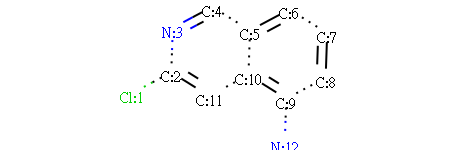

In [40]:
products[0]

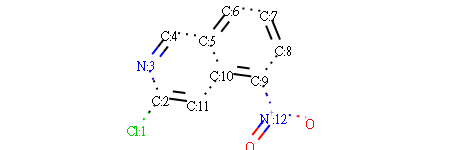

In [41]:
reactants[0]

In [50]:
p_atoms['2'].GetAtomicNum()

6

In [29]:
    reactant_frags, reactant_ids = fragmentize(reactants, changed_atoms, radius=1)
    product_frags, _ = fragmentize(products, changed_atoms, radius=0, include_unmapped=True, include_ids=reactant_ids)

    transform = '{}>>{}'.format(reactant_frags, product_frags)

    # Validate
    rxn = AllChem.ReactionFromSmarts(transform)
    _, n_errs = rxn.Validate(silent=True)
    if n_errs > 0:
        pass

    rxn_canonical = canonicalize_transform(transform)
    retro_canonical = convert_to_retro(rxn_canonical)
    NO_test= False
    rxn_canonical
    retro_canonical
    #reactants = rxn_canonical.split('>>')[0]
    #products  = rxn_canonical.split('>>')[1]
    #reactants
    # Don't force products to be from different molecules (?)
    # -> any reaction template can be intramolecular (might remove later)
    #products = products[1:-1].replace(').(', '.')

    # Don't force the "products" of a retrosynthesis to be two different molecules!
    #reactants = reactants[1:-1].replace(').(', '.')

    #return '>>'.join([products, reactants])

'([C;H0;+0:1]-[CH3;+0:2].[C@H;+0:3]-[NH2;+0:4])>>([C;H0;+0:1]-[CH2;+0:2]-[O;H0;+0]-[C;H0;+0](-[CH3;+0])=[O;H0;+0].[C@@H;+0:3]-[NH;+0:4]-[C;H0;+0](=[O;H0;+0])-[CH;+0](-[O;H0;+0]-[C;H0;+0](-[CH3;+0])=[O;H0;+0])-[c;H0;+0]1:[cH;+0]:[cH;+0]:[cH;+0]:[cH;+0]:[cH;+0]:1)'

In [30]:
    # Validate
    try:
        rxn = AllChem.ReactionFromSmarts(retro_canonical)
        _, n_errs = rxn.Validate(silent=True)
        if n_errs > 0:
            print('warning: {}'.format(retro_canonical))
            print('warning: {}'.format(smarts))
            #return    
    except Exception as e:
        print('warning5: {}'.format(e))
        print('transform: {}'.format(retro_canonical))
        print('smarts: {}'.format(smarts))
        #return
    n_errs
    val=[]
    val2=[]
    val=val_rc2(product, retro_canonical, reactant)
    if len(val)==2:
        val2=val_rc2(val[1], rxn_canonical, product)
    len(val) 

In [31]:
   len(val2)

1

In [53]:
        #,val_rc(products, retro_canonical, reactants)
#all([val_rc(reactants, rxn_canonical, products)])
#val_rc(reactants, rxn_canonical, products)
#val_rc(products, retro_canonical, reactants)
retro_canonical
#len(products)
len(reactants)
Chem.SanitizeMol(products)

ArgumentError: Python argument types in
    rdkit.Chem.rdmolops.SanitizeMol(MOL_SPTR_VECT)
did not match C++ signature:
    SanitizeMol(class RDKit::ROMol {lvalue} mol, unsigned __int64 sanitizeOps=rdkit.Chem.rdmolops.SanitizeFlags.SANITIZE_ALL, bool catchErrors=False)

In [32]:
    #def val_rc(reactants, reaction, products):
    '''This function checks if extracted rules are correct '''
    # Try all combinations of reactants that fit template
    rxn = AllChem.ReactionFromSmarts(rxn_canonical)
#    combinations = permutations(reactants, rxn.GetNumReactantTemplates())
    products_smi = [Chem.MolToSmiles(mol,allHsExplicit=True,allBondsExplicit=True) for mol in products]
    products_smi
    

[]

In [27]:
    
    for combination in combinations:
        outcomes = rxn.RunReactants(list(combination))
        if not outcomes: continue
        
        for outcome in outcomes:

            for k, product in enumerate(outcome):

                try:
                    Chem.SanitizeMol(product)
                    product.UpdatePropertyCache()
                except Exception as e:
                    print('warning: {}'.format(e))
                if Chem.MolToSmiles(product,allHsExplicit=True,allBondsExplicit=True) not in products_smi:
                    break
                if k == len(outcome)-1:
                    return True
    return False  
    

"\nfor combination in combinations:\n    outcomes = rxn.RunReactants(list(combination))\n    if not outcomes: continue\n    \n    for outcome in outcomes:\n\n        for k, product in enumerate(outcome):\n\n            try:\n                Chem.SanitizeMol(product)\n                product.UpdatePropertyCache()\n            except Exception as e:\n                print('warning: {}'.format(e))\n            if Chem.MolToSmiles(product,allHsExplicit=True,allBondsExplicit=True) not in products_smi:\n                break\n            if k == len(outcome)-1:\n                return True\nreturn False  \n"